In [ ]:
!git clone https://github.com/google/deluca.git

Cloning into 'deluca'...
remote: Enumerating objects: 2682, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 2682 (delta 288), reused 220 (delta 182), pack-reused 2297 (from 2)
Receiving objects: 100% (2682/2682), 3.44 MiB | 4.11 MiB/s, done.
Resolving deltas: 100% (1629/1629), done.


In [ ]:
%cd deluca

!pip install -e .

/content/deluca
Obtaining file:///content/deluca
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.7/711.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 15.5 MB/s eta 0:00:00
  Running setup.py develop for deluca


#This cell creates an LDS environment and plots the signal with random activations.

trajectory length = 1000


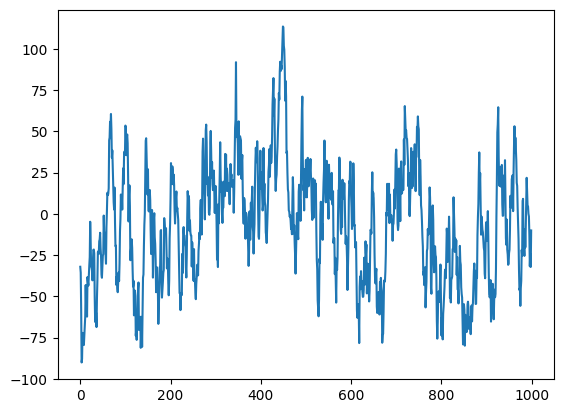

In [ ]:
%load_ext autoreload
%autoreload 2
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from deluca.core import Env
from deluca.core import field
from deluca.envs import _lds as lds
from deluca.envs._lds import SinusDisturbance



env = lds.LDS() #LDS with random initiations and dimensions as specified
#env = lds.LDS(2,10,3) #LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden,d_obs, disturbance = disturbance)
env.show_me_the_signal(1000)

Now I'd like to plot the signal with different activations, but instead of a build in function, i want to use agents.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TypeError: Array() takes no arguments

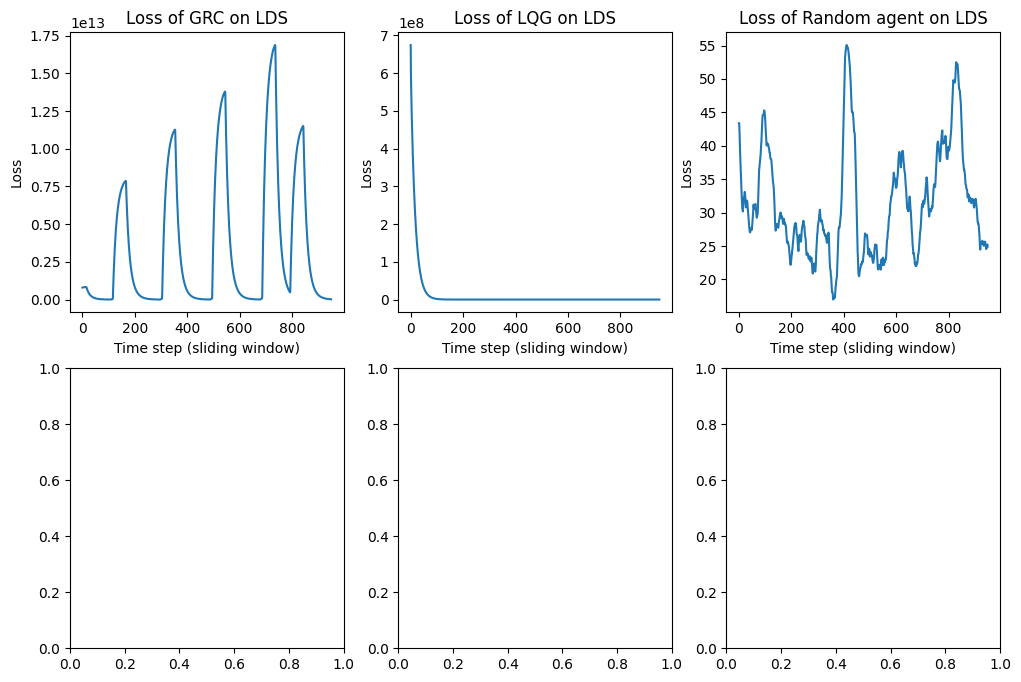

In [ ]:
# prompt: I want the same cell as above, but plot the figures side by side
%load_ext autoreload
%autoreload 2
from deluca.core import Agent
from deluca.agents._grc import GRC
from deluca.agents._random import SimpleRandom
from deluca.agents._lqg import LQG
from deluca.agents._zero import Zero
from deluca.agents._sfc import SFC
from deluca.agents._drc import DRC

import matplotlib.pyplot as plt
import numpy as np

def plot_lds_with_a_given_agent(env, agent, name_of_agent, traj_length=1000, window_size=50, ax=None):
    obs = np.zeros(shape=(d_obs, 1))
    action = agent(obs)
    losses = np.zeros(traj_length)
    window_losses = np.zeros(traj_length - window_size)

    for i in range(traj_length):
        obs = env(action)
        action = agent(obs)
        losses[i] = np.linalg.norm(obs) + np.linalg.norm(action) # simple quadratic loss
        agent.update(obs, action)
        if i >= window_size - 1:
            window_losses[i - window_size] = np.mean(losses[i - window_size + 1: i + 1])

    ax.plot(window_losses)
    ax.set_xlabel('Time step (sliding window)')
    ax.set_ylabel('Loss')
    ax.set_title(f"Loss of {name_of_agent} on LDS")


env = lds.LDS()  # LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden,d_obs, disturbance = disturbance)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()


agent = GRC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "GRC", ax=axes[0])

agent = LQG(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "LQG", ax=axes[1])

agent = SimpleRandom(d_action)
agent.init()
plot_lds_with_a_given_agent(env, agent, "Random agent", ax=axes[2])

agent = Zero(d_action)
agent.init(d_action)
plot_lds_with_a_given_agent(env, agent, "Zero agent", ax=axes[3])

agent = SFC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "SFC", ax=axes[4])

agent = DRC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "DRC", ax=axes[5])


plt.tight_layout()
plt.show()

In [ ]:
# prompt: I'd like to create a plot of the losses of all the agents from the previous cell on an LDS environment with:
# 1. random gaussian noise
# 2. sinusoidal noise
# 3. no noise at all
# please plot all of these 3 plots side by side
from deluca.core import Agent
from deluca.agents._grc import GRC
from deluca.agents._random import SimpleRandom
from deluca.agents._lqg import LQG
from deluca.agents._zero import Zero
from deluca.agents._sfc import SFC
from deluca.agents._drc import DRC

# Define the agents
agents = {
    "GRC": GRC(env.A, env.B, env.C),
    "LQG": LQG(env.A, env.B, env.C),
    "Random agent": SimpleRandom(d_action),
    "Zero agent": Zero(d_action),
    "SFC": SFC(env.A, env.B, env.C),
    "DRC": DRC(env.A, env.B, env.C),
}

# Initialize agents
for agent_name, agent_obj in agents.items():
    if hasattr(agent_obj, 'init'):
        if agent_name == "Zero agent":
            agent_obj.init(d_action)
        else:
            agent_obj.init()

# Define the different disturbance types
disturbances = {
    "Random Gaussian Noise": lds.GaussianDisturbance(std=0.1),
    "Sinusoidal Noise": lds.SinusDisturbance(),
    "No Noise": None,
}

fig, axes = plt.subplots(len(agents), len(disturbances), figsize=(15, 15))

for i, (agent_name, agent_obj) in enumerate(agents.items()):
    for j, (dist_name, disturbance_obj) in enumerate(disturbances.items()):
        # Create a new environment instance for each plot to ensure clean state
        env = lds.LDS()
        d_obs = 2
        d_action = 3
        d_hidden = 10

        # Initialize disturbance if it's not None
        if disturbance_obj:
            if hasattr(disturbance_obj, 'init'):
                if isinstance(disturbance_obj, lds.SinusDisturbance):
                    disturbance_obj.init(d_hidden, 0.5)
                elif isinstance(disturbance_obj, lds.GaussianDisturbance):
                    disturbance_obj.init(d_hidden, 0.1) # Initialize GaussianDisturbance

        # Initialize the environment
        obs = env.init(d_action, d_hidden, d_obs, disturbance=disturbance_obj)

        # Create a fresh instance of the agent for this specific environment and disturbance
        # This is crucial because agents maintain internal states (like Kalman filter states in LQG)
        # that are specific to the environment realization and disturbance.
        if agent_name == "GRC":
            current_agent = GRC(env.A, env.B, env.C)
        elif agent_name == "LQG":
            current_agent = LQG(env.A, env.B, env.C)
        elif agent_name == "Random agent":
            current_agent = SimpleRandom(d_action)
        elif agent_name == "Zero agent":
            current_agent = Zero(d_action)
        elif agent_name == "SFC":
            current_agent = SFC(env.A, env.B, env.C)
        elif agent_name == "DRC":
            current_agent = DRC(env.A, env.B, env.C)

        if hasattr(current_agent, 'init'):
            if agent_name == "Zero agent":
                current_agent.init(d_action)
            else:
                current_agent.init()

        plot_lds_with_a_given_agent(env, current_agent, f"{agent_name} with {dist_name}", ax=axes[i, j])
        axes[i, j].set_title(f"{agent_name} with\n{dist_name}") # Use different title style for clarity


plt.tight_layout()
plt.show()
